# Processing and Analysis of Raster Data

In the first part of our lesson, we reviewed the basics of raster files and explored how to read and work with both single-band and multiband raster files, as well as retrieve raster images via WMS. Now, in the second part of the lesson, we will focus on how to process and analyze raster data. Specifically, we will cover:

- Merging multiple raster files to create a `raster mosaic`
- Clipping rasters using a polygon
- Reclassifying raster data
- Performing `slope` analysis

For this part of the lesson, we will continue using the elevation model data with 2 more tiles.

✅ All DEMs reprojected to EPSG:3006


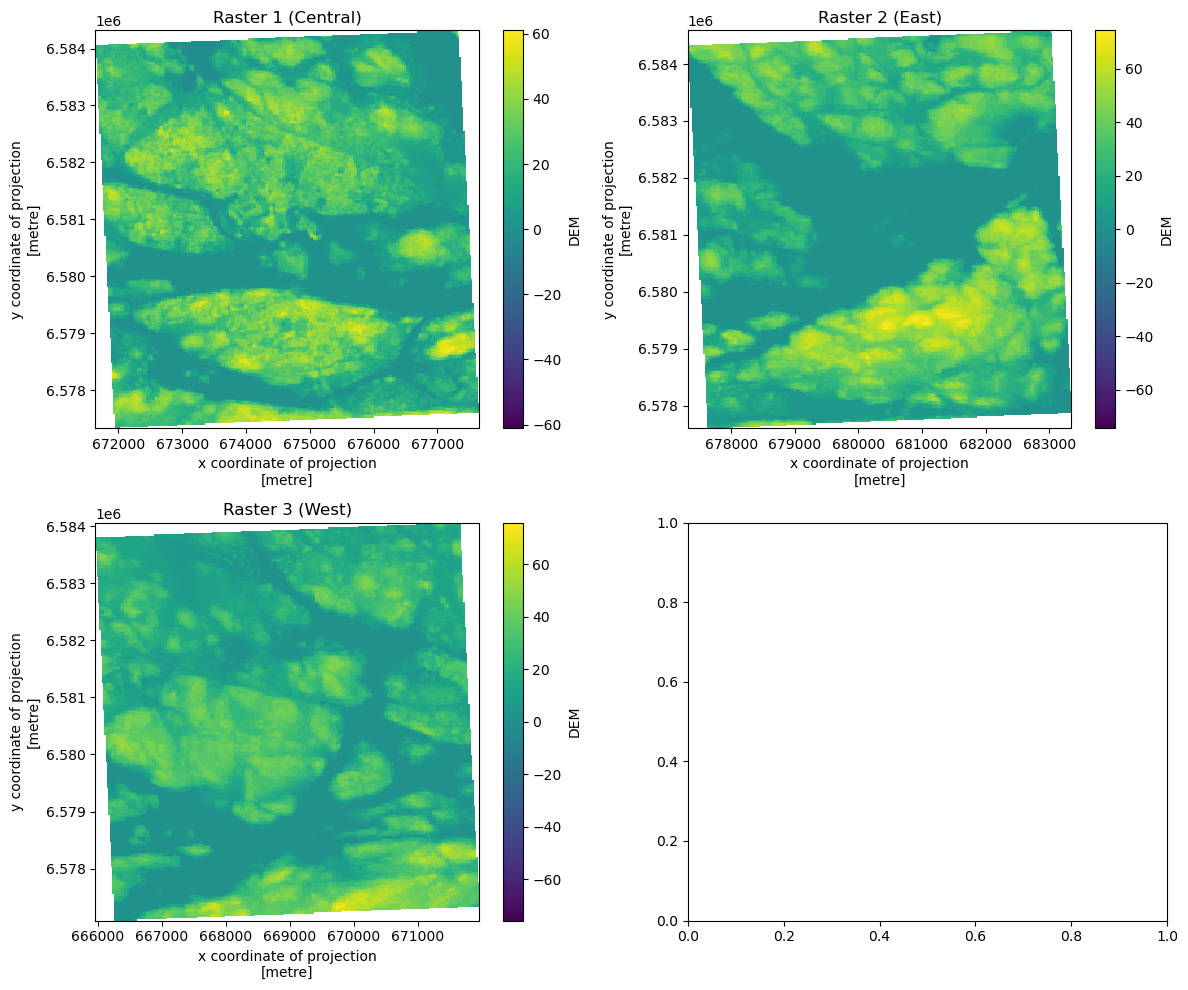

In [1]:
import rioxarray
import matplotlib.pyplot as plt

import rioxarray as rxr

# ✅ Load the DEMs
dem1 = rxr.open_rasterio('data/Stockholm_DEM.tif')  # Central
dem2 = rxr.open_rasterio('data/East_Stockholm_DEM_30m.tif')  # East
dem3 = rxr.open_rasterio('data/West_Stockholm_DEM_30m.tif')  # West

# ✅ Reproject each DEM to EPSG:3006
dem1_3006 = dem1.rio.reproject("EPSG:3006")
dem2_3006 = dem2.rio.reproject("EPSG:3006")
dem3_3006 = dem3.rio.reproject("EPSG:3006")


print("✅ All DEMs reprojected to EPSG:3006")

# Create a subplot with 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot each raster in a separate subplot
dem1_3006.plot(ax=axes[0, 0], cmap='viridis')
axes[0, 0].set_title('Raster 1 (Central)')

dem2_3006.plot(ax=axes[0, 1], cmap='viridis')
axes[0, 1].set_title('Raster 2 (East)')

dem3_3006.plot(ax=axes[1, 0], cmap='viridis')
axes[1, 0].set_title('Raster 3 (West)')



# Adjust layout
plt.tight_layout()
plt.show()

 In the next step, we will merge these tiles into a single raster mosaic, creating a seamless representation that covers the entire central area of Stockholm

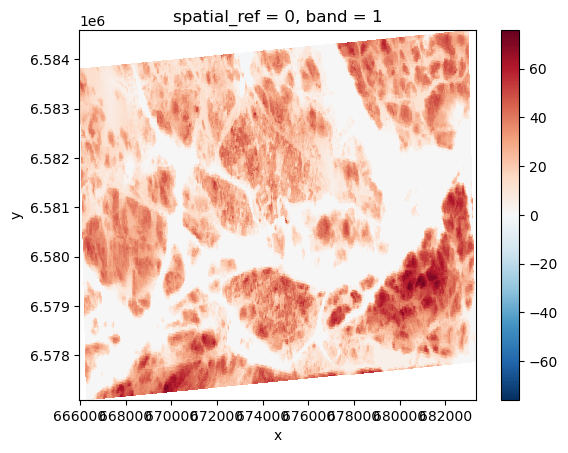

In [2]:
from rioxarray.merge import merge_arrays

# Merge the 3 raster data into one
mosaic_merged = merge_arrays([dem1_3006, dem2_3006, dem3_3006])

# Plot the mosaic raster
mosaic_merged.plot()

In [3]:

# ✅ Ensure the merged raster has proper metadata before saving
mosaic_merged = mosaic_merged.copy(deep=True)  # Ensures the object isn't in memory cache
mosaic_merged.rio.to_raster("merged_stockholm_dem.tif")



Lets try to use a Polygon layer now, to clip our raster to. Let's connect to the Stockholm municipalities service. We use an API to download data which you can request at the website. In case you don't have an API or the current one doesnt work, the file is available in the lecture folder as well.

In [4]:
from owslib.wfs import WebFeatureService
import requests

# Use one of your provided API keys
api_key = "8a5977e3-3c63-446b-90c0-0c079d0bef55"  # Replace with your actual API key

# Construct the WFS URL
wfs_url = f"https://openstreetgs.stockholm.se/geoservice/api/{api_key}/wfs"

# Try connecting to the WFS service
try:
    wfs = WebFeatureService(url=wfs_url, version='1.1.0')
    print("Connected to WFS successfully!")

    # List available layers in the WFS service
    print("\nAvailable layers in Stockholm's WFS:")
    for layer in wfs.contents:
        print(f"- {layer}")

except Exception as e:
    print(f"An error occurred: {e}")



Connected to WFS successfully!

Available layers in Stockholm's WFS:
- od_gis:Barmarksrenhallning
- od_gis:Belysningsmontage
- od_gis:Belysningsmontage_Punkt
- ltfr:LTFR_BOENDE
- od_gis:Bom
- od_gis:CityBikes
- od_gis:CityBikes_Punkt
- od_gis:Cykelparkering
- od_gis:Cykelparkering_Punkt
- od_gis:Cykelplan
- od_gis:Cykelplan_Linje
- od_gis:Cykelpump
- od_gis:Cykelpump_Punkt
- od_gis:Cykelraknare
- od_gis:Cykelstrak_Linje
- od_gis:Elsparkcykelplats_Yta
- ltfr:LTFR_FORESKRIFT_GEOM
- od_gis:Gatuarbete
- od_gis:Gatuarbete_Yta
- od_gis:Hundrastgard
- od_gis:Hundrastgard_Yta
- od_gis:Laddplats_Yta
- od_gis:Luftbrunn
- od_gis:Luftbrunn_Punkt
- od_gis:Markupplatelse
- od_gis:Markupplatelse_Punkt
- od_gis:Markupplatelse_Yta
- od_gis:NVDB_Bro_och_tunnel
- od_gis:NVDB_Barighet
- od_gis:NVDB_Cirkulationsplats
- od_gis:NVDB_Farthinder
- od_gis:NVDB_Framkomlighet_for_vissa_fordonskombinationer
- od_gis:NVDB_Funktionell_vagklass
- od_gis:NVDB_Farjeled
- od_gis:NVDB_Forbjuden_svang
- od_gis:NVDB_GCM-pa

Great, there is a bunch of data we can use. Let's try to work with the od_gis:Markupplatelse_Yta layer. We will import it from the service as an unprojected GML file.

In [5]:
from io import BytesIO
import geopandas as gpd
import requests
from owslib.wfs import WebFeatureService

# ✅ Step 1: Connect to WFS
api_key = "8a5977e3-3c63-446b-90c0-0c079d0bef55"  # Replace with your API key
wfs_url = f"https://openstreetgs.stockholm.se/geoservice/api/{api_key}/wfs"

try:
    wfs = WebFeatureService(url=wfs_url, version="1.1.0")
    print("✅ Connected to WFS successfully!")

except Exception as e:
    print(f"❌ WFS Connection Error: {e}")
    exit()

# ✅ Step 2: Fetch Layer Data in GML2
layer_name = "od_gis:Markupplatelse_Yta"
output_format = "GML2"  # Change this if another GML version is needed

try:
    # Get the WFS response in GML format
    gml_response = requests.get(
        wfs.getfeature(typename=layer_name, outputFormat=output_format).geturl()
    )
    gml_response.raise_for_status()  # Ensure request was successful

    # Load GML data into a GeoDataFrame
    gdf = gpd.read_file(BytesIO(gml_response.content))
    print(f"✅ Successfully loaded {layer_name} with {len(gdf)} features.")


except Exception as e:
    print(f"❌ Error fetching layer {layer_name}: {e}")


✅ Connected to WFS successfully!
✅ Successfully loaded od_gis:Markupplatelse_Yta with 31400 features.


From looking at the metadata of the service, the CRS they use is EPSG:3011. We will then define this projection for our layer - but we have to flip the coordinates as well. For some reason without the flipping the projection wont be correct!

In [9]:
from shapely.geometry import Polygon, MultiPolygon, LineString, Point


# ✅ Set correct CRS if not already assigned
gdf = gdf.set_crs("EPSG:3011")

# ✅ Function to Swap X and Y Coordinates
def swap_xy(geom):
    if geom.geom_type == "Polygon":
        return Polygon([(y, x) for x, y in geom.exterior.coords])
    elif geom.geom_type == "MultiPolygon":
        return MultiPolygon([
            Polygon([(y, x) for x, y in poly.exterior.coords]) for poly in geom.geoms
        ])
    elif geom.geom_type == "LineString":
        return LineString([(y, x) for x, y in geom.coords])
    elif geom.geom_type == "Point":
        return Point(geom.y, geom.x)
    else:
        return geom  # Leave other geometries unchanged

# ✅ Apply the Swap Function
gdf["geometry"] = gdf["geometry"].apply(swap_xy)

# ✅ Save the Fixed Data (Optional)
gdf.to_file("polygonlayer.geojson", driver="GeoJSON")

print("✅ Coordinates flipped and saved as 'polygonlayer.geojson'")


C:\Users\sgeor\miniconda3\envs\geopython_raster\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


✅ Coordinates flipped and saved as 'polygonlayer.geojson'


<Axes: >

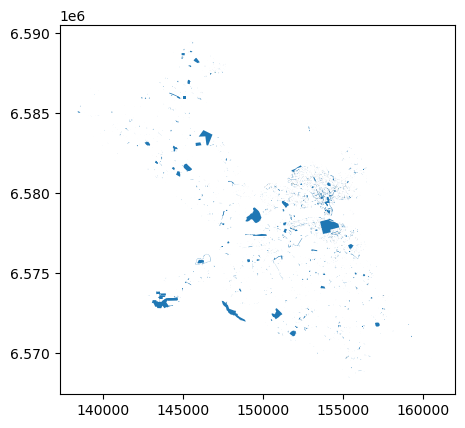

In [10]:
gdf.plot()

In [11]:
# Transfrom the polygon to the same CRS as our raster data
gdf = gdf.to_crs(mosaic_merged.rio.crs)

In [12]:
gdf.crs

<Projected CRS: EPSG:3006>
Name: SWEREF99 TM
Axis Info [cartesian]:
- [north]: Northing (metre)
- [east]: Easting (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: SWEREF99
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Let's do the clip now!

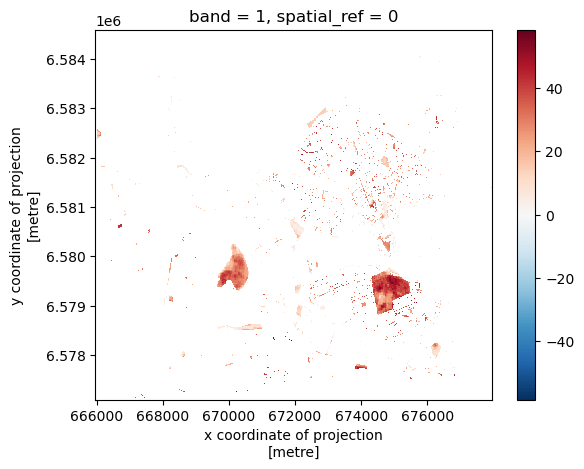

In [13]:
# Double check that the CRS match
assert mosaic_merged.rio.crs == gdf.crs , "CRS Mismatch"

# Clip the raster using the Kamppi polygon
clipped_mosaic = mosaic_merged.rio.clip(gdf.geometry, gdf.crs)

clipped_mosaic.plot()

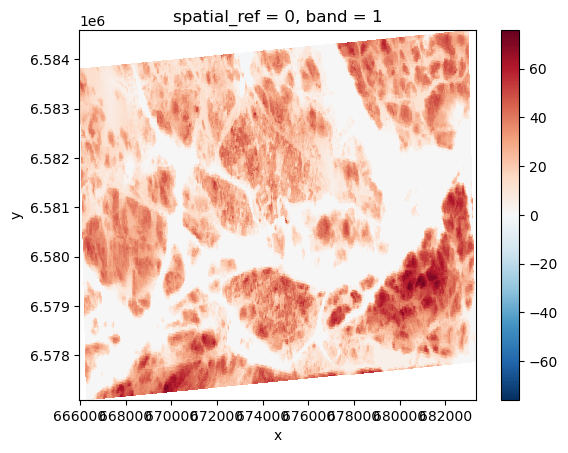

In [14]:
mosaic_merged.plot()

## Raster reclassification

**Raster reclassification** is another common procedure with raster dataset. Raster reclassification is the process of assigning new values to the pixels of a raster dataset based on their existing values. This is often used to simplify or categorize continuous data, such as elevation or land cover, into distinct classes. For example, in an elevation map, reclassification can group different elevation ranges into categories like "low", "medium", and "high" altitude, making it easier to analyze or visualize the data for specific applications such as hazard assessment or land management.

let's first have a look at the range of values (altitudes) in our raster data:

In [15]:
# Check the data range
print(clipped_mosaic.min().values, clipped_mosaic.max().values)

-1.0094962 58.390923


Now we want to reclassify our data using two approaches. First, let's do it manually using the `numpy` library. **[NumPy](https://numpy.org/doc/)** is a powerful Python library used for numerical and scientific computing. It provides support for large, multi-dimensional arrays and matrices, along with a wide collection of mathematical functions to operate on these arrays efficiently. So basically here, we are treating our pixel values as an `Array` and do the calculations accordingly. 

> **Note:**
> An **array** (such as those created by NumPy) is a multi-dimensional container for data, but it lacks metadata like coordinate labels or attributes. In contrast, an **xarray.DataArray** enhances the array by adding labeled dimensions, coordinates, and attributes, making it easier to work with multi-dimensional data, especially in geospatial and time-series contexts.


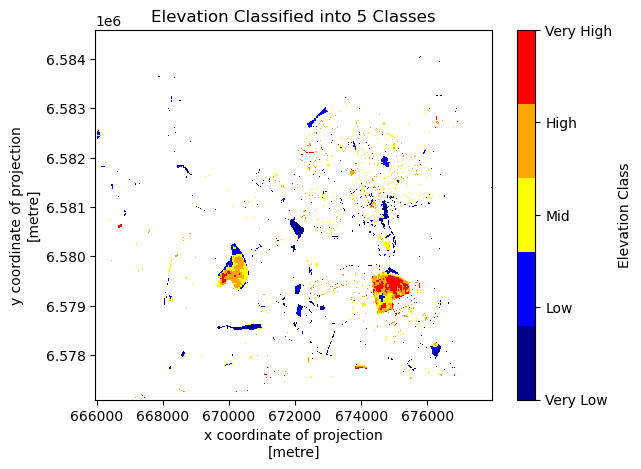

In [16]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt


# 1. Define bins for  5 classes 
bins = [-2, 10, 20, 30, 40, np.inf]

# 2. Create a mask to preserve NaNs and ignore them during reclassification
masked_raster = np.where(~np.isnan(clipped_mosaic), clipped_mosaic, np.nan)

# 3. Use np.digitize to assign class IDs. 
#    'right=False' means the left side of each interval is inclusive.
reclassified_array = np.digitize(masked_raster, bins, right=False)

# 4. Preserve existing NaNs (they currently become 0 by digitize)
#    We'll re-inject NaN where the original array had NaN
reclassified_array = np.where(~np.isnan(masked_raster), reclassified_array, np.nan)

# 5. Convert the numpy array into an xarray DataArray
reclassified_raster = xr.DataArray(
    reclassified_array,
    dims=clipped_mosaic.dims,
    coords=clipped_mosaic.coords,
    attrs=clipped_mosaic.attrs
)

# 6. Create a 5-color colormap (one color for each class)
color_list = ['darkblue', 'blue', 'yellow', 'orange', 'red']
custom_cmap = plt.matplotlib.colors.ListedColormap(color_list)

# 7. Plot with xarray's .plot(), specifying our custom cmap
plot_obj = reclassified_raster.plot(cmap=custom_cmap)

# 8. Customize the colorbar: set the tick positions and labels
cbar = plot_obj.colorbar
cbar.set_ticks([1, 2, 3, 4, 5])  # Class IDs
cbar.set_ticklabels(['Very Low', 'Low', 'Mid', 'High', 'Very High'])  
cbar.set_label("Elevation Class")

# 9. Set a plot title and show
plt.title("Elevation Classified into 5 Classes")
plt.show()


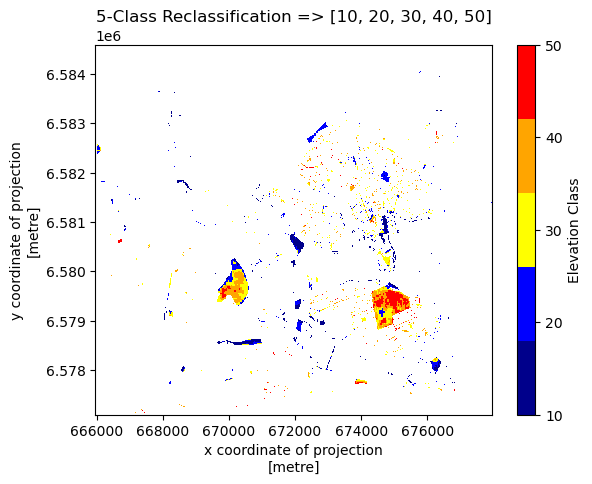

In [17]:
bins = [-2, 10, 20, 30, 40, np.inf]
new_values = [10, 20, 30, 40, 50]  # 5 possible final values

masked = np.where(~np.isnan(clipped_mosaic), clipped_mosaic, np.nan)
digitized = np.digitize(masked, bins, right=False)

# Clamp 0 -> 1, clamp > 5 -> 5
digitized = np.where(digitized < 1, 1, digitized)
digitized = np.where(digitized > 5, 5, digitized)

# Subtract 1 => [0..4], index into new_values
zero_based = digitized - 1  
mapped_array = np.full_like(zero_based, np.nan, dtype=float)

valid_mask = ~np.isnan(zero_based)
mapped_array[valid_mask] = np.take(new_values, zero_based[valid_mask].astype(int))

mapped_array = np.where(~np.isnan(masked), mapped_array, np.nan)

reclassified_raster = xr.DataArray(
    mapped_array,
    dims=clipped_mosaic.dims,
    coords=clipped_mosaic.coords,
    attrs=clipped_mosaic.attrs
)

# For display, since your final data is [10..50],
# we can do a colorbar with 5 colors:
cmap = plt.matplotlib.colors.ListedColormap(['darkblue','blue','yellow','orange','red'])
plot_obj = reclassified_raster.plot(cmap=cmap, add_colorbar=False)

cbar = plt.colorbar(plot_obj)
cbar.set_ticks(new_values)  # [10,20,30,40,50]
cbar.set_ticks([10, 20, 30, 40, 50])
cbar.set_label("Elevation Class")

plt.title("5-Class Reclassification => [10, 20, 30, 40, 50]")
plt.show()


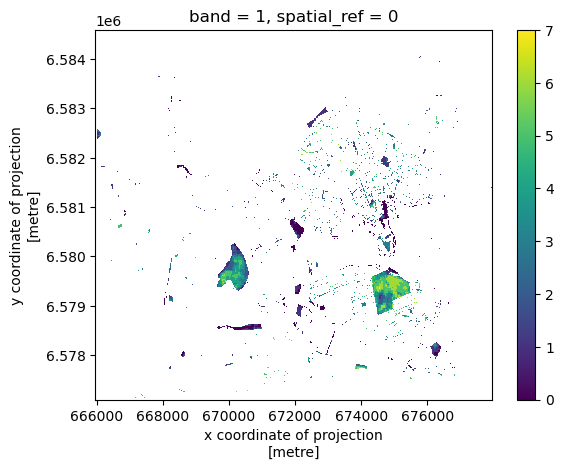

In [18]:
import mapclassify

# Flatten the raster data and store the original shape
raster_data_flattened = clipped_mosaic.values.flatten()
original_shape = clipped_mosaic.shape

# Create a mask for NaN values and remove NaNs for classification
nan_mask = np.isnan(raster_data_flattened)
raster_data_no_nan = raster_data_flattened[~nan_mask]

# Apply Natural Breaks classification with 7 classes
natural_breaks = mapclassify.NaturalBreaks(raster_data_no_nan, k=7)

# Get the classified bins
breaks = natural_breaks.bins

# Classify the non-NaN raster values
classified_raster = np.digitize(raster_data_no_nan, bins=breaks)

# Create an array to hold the full reclassified data
reclassified_full_raster = np.full_like(raster_data_flattened, np.nan)

# Insert the classified data back, keeping NaNs in place
reclassified_full_raster[~nan_mask] = classified_raster

# Reshape the reclassified raster to its original shape
reclassified_full_raster = reclassified_full_raster.reshape(original_shape)

# Convert to xarray DataArray
reclassified_raster_nb = xr.DataArray(
    reclassified_full_raster,
    dims=clipped_mosaic.dims,
    coords=clipped_mosaic.coords,
    attrs=clipped_mosaic.attrs
)

# Plot the reclassified raster
reclassified_raster_nb.plot()


## Slope analysis

**Slope analysis** is a key terrain analysis technique used in GIS and spatial analysis to measure the steepness or incline of the terrain at any given point. It is calculated by examining the rate of change in elevation between neighboring pixels in a digital elevation model (DEM). Slope analysis helps identify areas with steep gradients, which is useful in applications like land-use planning, erosion risk assessment, hydrological modeling, and infrastructure development. The slope is typically expressed in degrees or as a percentage.


We will be using our mossaiced raster.

1. **Gradient Calculation**: We use the elevation differences between adjacent cells in both the x (horizontal) and y (vertical) directions. The gradient represents how quickly elevation changes in these directions.
   
2. **Slope Formula**: The slope is calculated by combining these gradients using the Pythagorean theorem:
$$
\text{slope} = \sqrt{\left(\frac{\Delta z}{\Delta x}\right)^2 + \left(\frac{\Delta z}{\Delta y}\right)^2}
$$

where Delta z  is the change in elevation, and Delta x and Delta y are the distances between the cells in the x and y directions.


3. **Final Slope Values**: The result is often expressed in degrees or as a percentage, with steeper areas showing higher slope values. We use degrees here. 

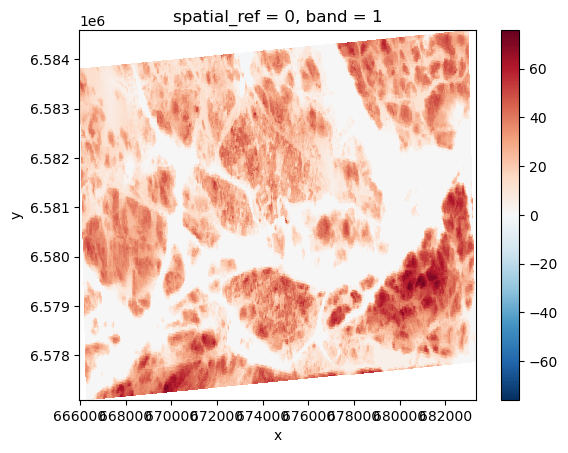

In [19]:
mosaic_merged.plot()

In [20]:
# Get the pixel resolution 
xres = mosaic_merged.rio.resolution()[0]  # Resolution in x direction (longitude)
yres = mosaic_merged.rio.resolution()[1]  # Resolution in y direction (latitude)

# Calculate gradients in the x and y directions
dzdx = mosaic_merged.differentiate(coord='x') / xres  # Gradient in the x direction
dzdy = mosaic_merged.differentiate(coord='y') / yres  # Gradient in the y direction

# Calculate the slope (in degrees)
slope = np.sqrt(dzdx**2 + dzdy**2)
slope = np.arctan(slope) * (180 / np.pi)

# Update the attributes to reflect that this is a slope raster
slope.attrs['long_name'] = 'Slope'
slope.attrs['units'] = 'degrees'

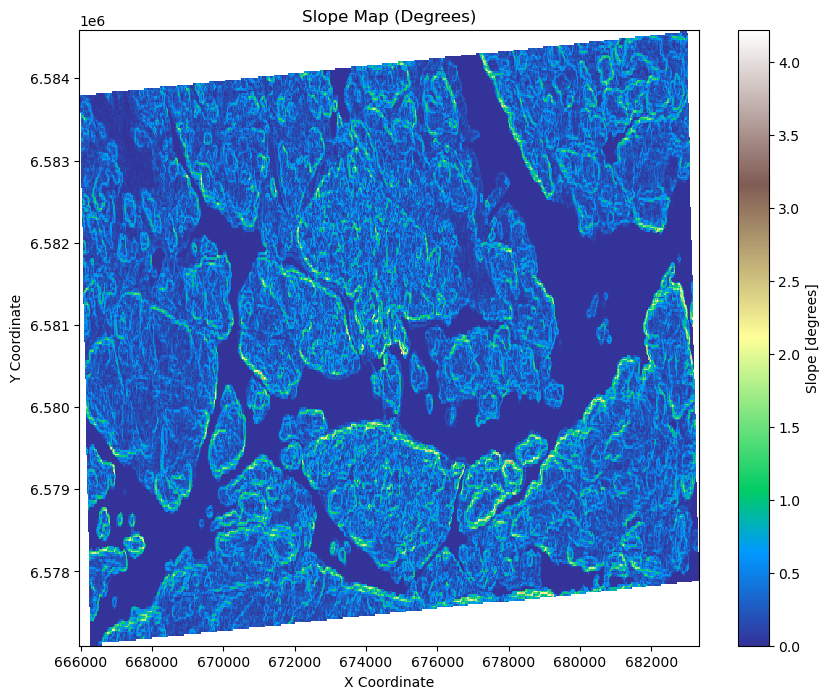

In [21]:
# Plot the slope raster
plt.figure(figsize=(10, 8))
slope.plot(cmap='terrain', add_colorbar=True)
plt.title("Slope Map (Degrees)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

## Aspect is the compass direction of the slope (e.g., 0° = north, 90° = east, 180° = south, 270° = west). 

In [23]:
# Suppose you already have:
# dzdx = mosaic_merged.differentiate('x') / xres
# dzdy = mosaic_merged.differentiate('y') / yres
# (from your existing slope code)

# 1) Compute aspect in radians, referencing north = 0°, 
#    positive clockwise.
aspect_radians = np.arctan2(dzdy, -dzdx)

# 2) Convert to degrees and map to [0..360)
aspect_degrees = (aspect_radians * (180.0 / np.pi)) % 360.0

# 3) Wrap it in an xarray, preserving coordinates/attributes
aspect = xr.DataArray(
    aspect_degrees,
    dims=mosaic_merged.dims,
    coords=mosaic_merged.coords,
    attrs={
        'long_name': 'Aspect',
        'units': 'degrees (0=N, 90=E, 180=S, 270=W)'
    }
)


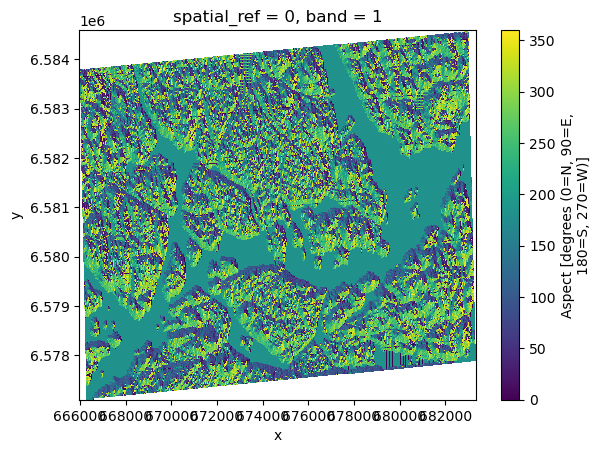

In [24]:
aspect.plot()

## A hillshade simulates how the terrain would appear under a particular sun azimuth and altitude

In [25]:

# We'll pick typical hillshade parameters:
alt_deg = 45.0   # sun altitude above horizon
az_deg  = 315.0  # sun azimuth (clockwise from north)

# Convert to radians
alt_rad = np.deg2rad(alt_deg)
az_rad  = np.deg2rad(az_deg)

# Slope in radians => from your slope (in degrees)
slope_rad = np.deg2rad(slope)  # 'slope' from your existing calculation

# Aspect in radians => let's re-derive or if you saved aspect_radians, reuse it:
aspect_radians = np.arctan2(dzdy, -dzdx)

# Hillshade formula:
hillshade_values = 255.0 * (
    np.sin(alt_rad) * np.sin(slope_rad)
    + np.cos(alt_rad) * np.cos(slope_rad)
      * np.cos(az_rad - aspect_radians)
)

# Optional: clip negative values to 0 if you want shading only in [0..255]
hillshade_values = np.clip(hillshade_values, 0, 255)

hillshade = xr.DataArray(
    hillshade_values,
    dims=mosaic_merged.dims,
    coords=mosaic_merged.coords,
    attrs={
        'long_name': 'Hillshade',
        'units': '0-255 (8-bit shading)'
    }
)


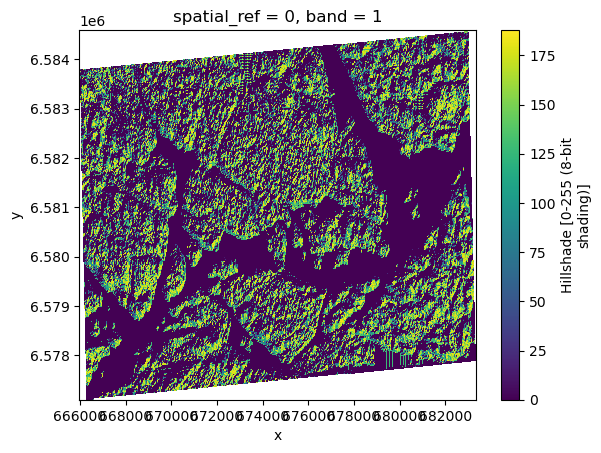

In [26]:
hillshade.plot()

## A simple measure of curvature is to take the second derivatives in both 𝑥  and y directions and sum them. 

In [27]:

# Already have:
# dzdx = ...
# dzdy = ...

# Take second derivatives
d2zdx2 = dzdx.differentiate('x') / xres
d2zdy2 = dzdy.differentiate('y') / yres

curvature_values = d2zdx2 + d2zdy2

curvature = xr.DataArray(
    curvature_values,
    dims=mosaic_merged.dims,
    coords=mosaic_merged.coords,
    attrs={
        'long_name': 'Curvature (2nd derivative)',
        'units': '1/meter^2 (approx)'
    }
)


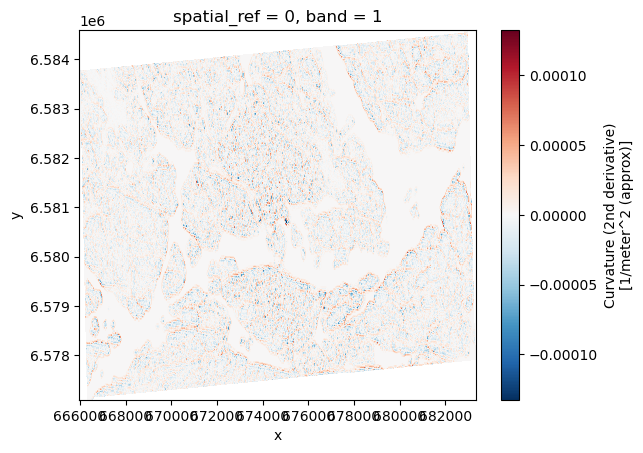

In [28]:
curvature.plot()

saving a raster as a file

In [29]:
import rioxarray

# Ensure the DataArray has CRS information
curvature.rio.write_crs(mosaic_merged.rio.crs, inplace=True)

# Save as GeoTIFF
curvature.rio.to_raster("curvature.tif")

print("✅ Curvature raster saved as 'curvature.tif'")



✅ Curvature raster saved as 'curvature.tif'


## Sources

This lesson is inspired and has adapted or reused material from University of Helsinki Automating GIS processis course (https://autogis-site.readthedocs.io/en/latest/course-info/license.html) under a Creative Commons Attribution-ShareAlike 4.0 International licence (https://creativecommons.org/licenses/by-sa/4.0/deed.en).